In [ ]:
import requests
import pandas as pd
import json
import mysql.connector
from datetime import datetime, timedelta
import time
import nvda_config1

import twelvedata
from twelvedata import TDClient

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Including this login info just in case 
Cpassword = nvda_config1.mysql_password
td = TDClient(apikey=nvda_config1.twelve_api_nvda) 
base_url = 'https://api.twelvedata.com'

# Establish MySQL object
mydb = mysql.connector.connect(
    host="localhost",   
    user="root",         
    password=Cpassword,  
    database="nvdav1"   
)

mycursor = mydb.cursor()



In [ ]:
# Read CSV files and create pandas dataframes
# Stock prices foor NVDA historical for 1 yeaar at 1 minute intervals
df_stock = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/stock_ticks.csv')
# technical inidcators foor NVDA historical for 1 yeaar at 1 minute intervals
df_ti = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/technical_indicators.csv')
# company info
df_nvda_info = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/nvda_profile.csv')
# new data for recent days downlaoded by the minute. Will have errors
df_recent_new = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/nvda_new.csv')
# data for nvda earnings
df_nvda_earnings = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/NVDA_earnings.csv')
# aux historical
df_aux = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/aux_historical_data.csv')
# spx historical
df_spx = pd.read_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/spx_historical_data.csv')
# Display the first few rows of each dataframe to verify the data
print("Stock Data:")
print(df_stock.head())
print("\nTI Data:")
print(df_ti.head())


The files being read in above are results of the extract_from_sql_tool which taps into the MYSQL server and extracts the entirety of the table. These tables are not altered and so will contain all information gathered on that entity. Keeping the code above to run everytime is ok. 

*****TO DO***********
GENERATE CODE TO LIST NAMES OF ATTRIBUTES
UNIFY NAMES AND DATA TYPES
GENERATE CODE TO PULL MOST COMMON MINIMUM AND MAXIMUM DATES
TRIM AND MERGE


In [ ]:

#print("\nColumns in NVDA Earnings Data:")
#print(df_nvda_earnings.columns)
#print("\nColumns in NVDA Info Data:")
#print(df_nvda_info.columns)
#print("\nColumns in NVDA Recent New Data:")
#print(df_recent_new.columns)

print("\nColumns in AUX historical:")
print(df_aux.columns)
print("\nColumns in SPX historical:")
print(df_spx.columns)
print("Columns in Stock Data:")
print(df_stock.columns)
print("\nColumns in Technical Indicators Data:")
print(df_ti.columns)



In [ ]:
# Renaming columns for AUX
df_aux.rename(columns={
    "open": "aux_open", 
    "close": "aux_close", 
    "high": "aux_high",
    "low": "aux_low",
    "close": "aux_close", 
    "macd": "aux_macd",
    "macd_signal": "aux_macd_signal",
    "macd_hist": "aux_macd_hist",
    "ema": "aux_ema",
    "rsi": "aux_rsi"
}, inplace=True)

# Renaming columns for SPX
df_spx.rename(columns={  
    "open": "spx_open", 
    "close": "spx_close", 
    "high": "spx_high",
    "low": "spx_low",
    "close": "spx_close", 
    "macd": "spx_macd",
    "macd_signal": "spx_macd_signal",
    "macd_hist": "spx_macd_hist",
    "ema": "spx_ema",
    "rsi": "spx_rsi",
}, inplace=True)

df_stock.drop(columns=['id', 'symbol'], inplace=True)
df_ti.drop(columns=['id', 'symbol'], inplace=True)



In [ ]:
# While experimenting downloading via api there are diplicates needing to be removed

duplicate_entries = df_stock['datetime'].duplicated().any()
if duplicate_entries:
    print("There are duplicate datetime entries.")
else:
    print("No duplicate datetime entries found.")

duplicate_entries = df_stock[df_stock['datetime'].duplicated(keep=False)]
print(duplicate_entries)


In [ ]:
def print_df_columns(df_list):
    for df in df_list:
        print(f"Columns in: df")
        print(df.columns)
        print("\n")
dfs = [df_nvda_earnings, df_nvda_info,  df_ti, df_aux, df_spx]
print_df_columns(dfs)

In [ ]:
df_stock = df_stock.drop_duplicates(subset='datetime', keep='first')
df_stock = df_stock.rename(columns={'volume':'nvda_volume',
    'open':'nvda_open',
    'close':'nvda_close',
    'high':'nvda_high',
    'low':'nvda_low'
})
df_ti = df_ti.rename(columns={'bydatetime':'datetime',
    'ema':'nvda_ema',
    'rsi':'nvda_rsi'
})
df_ti = df_ti.drop_duplicates(subset='datetime', keep='first')

In [ ]:
df_stock_ti = pd.merge(df_stock, df_ti, on='datetime', how='inner')


The length of the CSV is 75065 after discounting the Header row. The length of the stock_ticks and TI csv's are the same. The length of stock ticks after removing duplicates and joining with TI are both 70061. Dividing by 390 (minutes in a day) we arrive at 179 days with 250 minutes in remainder. This didn't check out at first so I did further research and discovered that certain days afaetr holidays the stock market closes early. 
https://www.nyse.com/markets/hours-calendars



In [ ]:
print(len(df_stock))
print(df_stock_ti.columns)
df_stock_ti = df_stock_ti.rename(columns={'bysignal': 'nvda_signal', 'byhistogram': 'nvda_hist'})

Now we can proceed with joining SPX and AUX in similar fashion and then left joining on NVDA so as to match it's timeframe. 

In [ ]:
df_aux_spx = pd.merge(df_aux, df_spx, on='datetime', how='left')
print(len(df_aux_spx))

In [ ]:
nvda_db = pd.merge(df_stock_ti, df_aux_spx, on='datetime', how='left')
print(len(nvda_db))

In [ ]:
nvda_db = nvda_db.sort_values(by='datetime', ascending=True)
nvda_db['datetime'] = pd.to_datetime(nvda_db['datetime'])

# Extract time-based features
nvda_db['HourOfDay'] = nvda_db['datetime'].dt.hour
nvda_db['DayOfWeek'] = nvda_db['datetime'].dt.dayofweek 


In [ ]:
nvda_db.to_csv('C:/Users/micha/OneDrive/Desktop/NVDALinearLogisticAnalysis/nvda_db.csv', index=False)

Date range of all combined is 7/5/2023 to 8/2/2024

<Axes: >

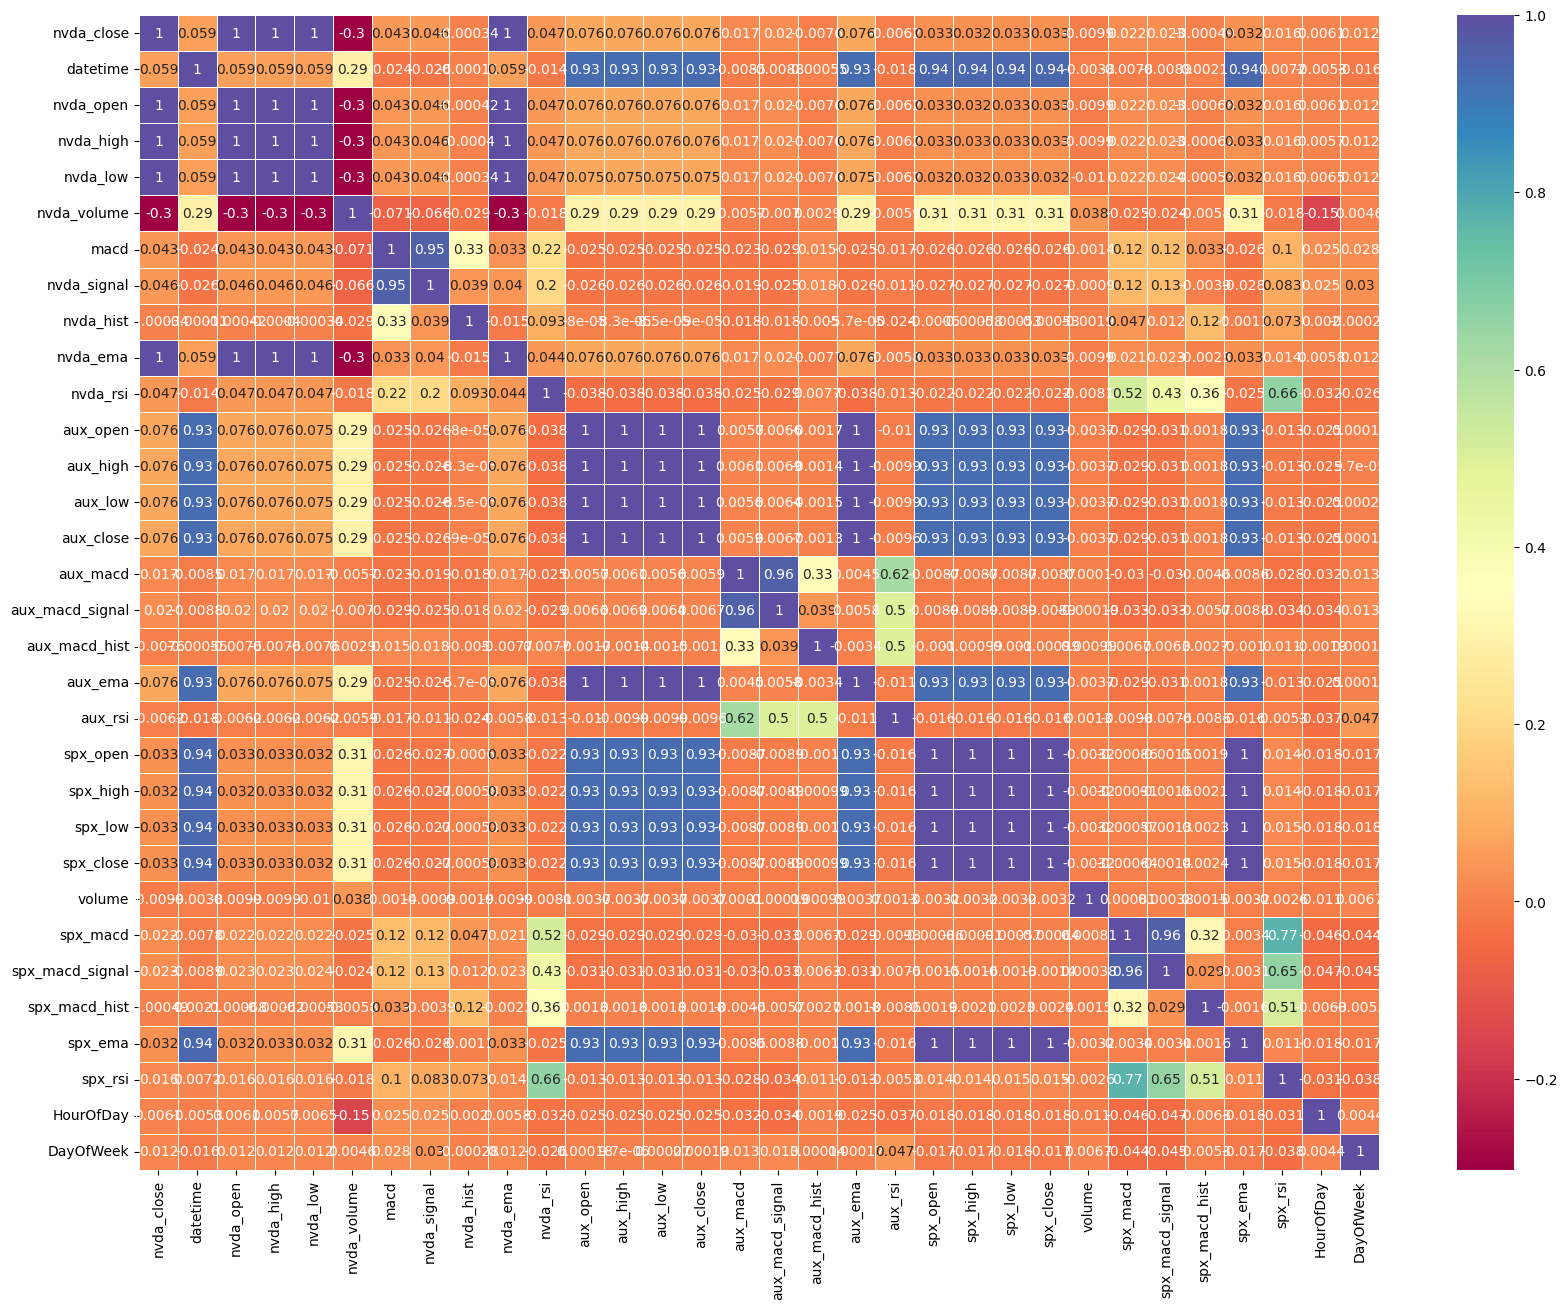

In [81]:
nvda_db = nvda_db[ ['nvda_close'] + [ col for col in nvda_db.columns if col != 'nvda_close' ] ]


plt.subplots(figsize=(20,15))

dfCorr = nvda_db.corr()
sns.heatmap(dfCorr, linewidth=.5, cmap = "Spectral", annot = True)

In [82]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print('Mean Squared Error:', mean_squared_error(Y_test, Y_pred))


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values